In [ ]:
# Reference
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [2]:
import gym

import torch
import numpy as np
from torch import nn
import torch.nn.functional as F

from torch.optim import Adam as Optimizer

In [3]:
class Qnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input_size = 4
        self.dim1 = 100
        self.dim2 = 100
        self.dimf = 100
        self.output_size = 2
        
        # Actor
        self.X = nn.Linear(self.input_size, self.dim1)
        self.X1 = nn.Linear(self.dim1, self.dim2)
        self.X2 = nn.Linear(self.dim2, self.dimf)
        self.Xf = nn.Linear(self.dimf, self.output_size)        
    
    def forward(self, observation):
        
        x = F.relu(self.X(observation))
        x = F.relu(self.X1(x))
        x = F.relu(self.X2(x))
        x = self.Xf(x)
        prob = F.softmax(x,dim=1)
        
        return prob

In [5]:
#del approx_value, target_value

# Instances
env = gym.make('CartPole-v1')
approx_value = Qnet()
target_value = Qnet()
target_value.load_state_dict(approx_value.state_dict())
optimizer = Optimizer(approx_value.parameters(), lr=1e-5)

# settings
epi = 20000
time = 500
store_episode = -torch.ones(epi)

# Roll-out
for i_episode in range(epi):
    
    store_observation = -torch.ones(time,4)
    store_action = torch.zeros(time)
    store_reward = torch.zeros(time)
    observation = env.reset()[0]
    
    ###########
    # Roll-out
    ###########
    for t in range(time):
        
        # action from value function Q
        observation = torch.from_numpy(observation)
        values = approx_value.forward(observation[None,:])
        values = values[0,:]
        
        action = values.argmax().detach().item()
        value_select = values[action]

        store_observation[t,:] = observation
        store_action[t] = action
        
        # next state
        observation, reward, done, _, _ = env.step(action)

        if done:
            reward = -1
        store_reward[t] = reward
        
        if done:
            break

    if i_episode %200 ==0:
        print(("Episode finished after {} timesteps".format(t+1)))
    
    store_episode[i_episode] = t+1
    
    ###########
    # Training
    ###########
    # sampling
    #n_sample = np.ceil(ratio*(t+1)).astype(np.int64) # use 50% of data for training
    n_sample = min(20, np.ceil(0.7*(t+1)).astype(np.int64))
    sample_idx = torch.randperm(t)[:n_sample]
    sample_idx_obs = sample_idx[:,None].expand(-1,4)
    
    sampled_obs_current = store_observation.gather(0,sample_idx_obs)
    sampled_action = store_action.gather(0,sample_idx).long()
    
    # Current Values
    Qcurrent = approx_value.forward(sampled_obs_current)
    Qcurrent_max = Qcurrent.gather(1,sampled_action[:,None])
    
    # Target Values
    sampled_obs_next = store_observation.gather(0,sample_idx_obs+1)
    with torch.no_grad():
        reward = store_reward[t]
        Qtarget = target_value.forward(sampled_obs_next)
        Qtarget_max = reward + 0.99*Qtarget.max(1,keepdim=True).values
        #Qtarget_max = torch.where(sample_idx[:,None]+1==t, -5*torch.ones_like(Qtarget_max), 5+0.95*Qtarget_max)
    
    TD = Qtarget_max - Qcurrent_max
    loss = (0.5*TD*TD).sum()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Value network synchronization
    # Soft update
    if i_episode %200 ==0:
        TAU = 0.01
        target_net_state_dict = target_value.state_dict()
        approx_net_state_dict = approx_value.state_dict()
        for key in approx_net_state_dict:
            target_net_state_dict[key] = approx_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_value.load_state_dict(target_net_state_dict)
    
env.close()

#del approx_value, target_value, optimizer

Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 17 timesteps
Episode finished after 27 timesteps
Episode finished after 10 timesteps
Episode finished after 11 timesteps
Episode finished after 23 timesteps
Episode finished after 27 timesteps
Episode finished after 12 timesteps
Episode finished after 21 timesteps
Episode finished after 43 timesteps
Episode finished after 14 timesteps
Episode finished after 12 timesteps
Episode finished after 39 timesteps
Episode finished after 11 timesteps
Episode finished after 27 timesteps
Episode finished after 26 timesteps
Episode finished after 19 timesteps
Episode finished after 63 timesteps
Episode finished after 10 timesteps
Episode finished after 25 timesteps
Episode finished after 28 timesteps
Episode finished after 25 timesteps
Episode finished after 25 timesteps
Episode finished after 42 timesteps
Episode finished after 11 timesteps
Episode finished after 15 timesteps
Episode finished after 93 tim

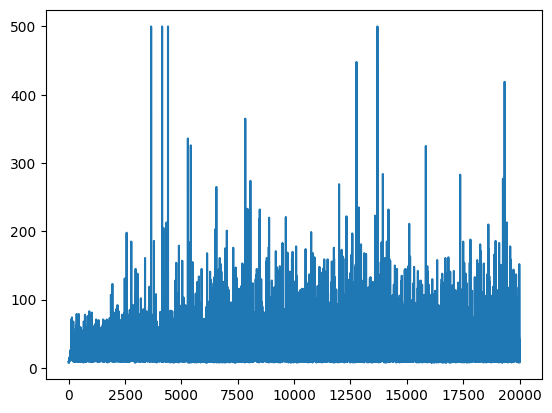

In [6]:
import matplotlib.pyplot as plt

x = np.arange(0,i_episode)
y = store_episode[0:i_episode].numpy()

fig, ax = plt.subplots()
ax.plot(x,y)

In [8]:
torch.save(store_episode[0:i_episode+1], "DQN_result")